## Sustainable and Entrepreneurial Finance- Homework #1

In [2]:
#Necessary libraries to run the code
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Question 3- Optimizing the portfolio

In [3]:
from scipy.optimize import minimize

file_path = r"data_h1/filtered_data\DS_RI_USD_M.xlsx"

#Filtering the data frame and using data only from 2014 to 2024
df_returns = pd.read_excel(file_path, sheet_name="MR raw", index_col=0, parse_dates=True)
df_returns = df_returns.select_dtypes(include=[np.number])
df_returns.columns = pd.to_datetime(df_returns.columns, format='%Y-%m-%d', errors='coerce')
df_returns=df_returns.loc[:, "2014-01-31":"2024-12-31"]

#Computing the mean and the covariance matrix 
mu_hat = df_returns.mean(axis=1,skipna=True)
Sigma_hat = df_returns.T.cov()

# Number of assets
n_assets = len(mu_hat)

# Convert expected returns and covariance matrix to NumPy arrays
mu_array = mu_hat.values.reshape(-1, 1)  # Column vector
Sigma_array = Sigma_hat.values  # Covariance matrix

# Constraint: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: No short selling (weights >= 0)
bounds = [(0, 1) for _ in range(n_assets)]

### Step 1: Compute Minimum Variance Portfolio (MVP)
def portfolio_variance(w, Sigma):
    return w.T @ Sigma @ w

# Initial guess (equal weights)
w0 = np.ones(n_assets) / n_assets

# Solve for minimum variance portfolio
Sigma_array = np.nan_to_num(Sigma_array)  #remove Nan for non-overlapping returns for some companies

mvp_result = minimize(portfolio_variance, w0, args=(Sigma_array,), method='SLSQP', bounds=bounds, constraints=constraints)
w_mvp = mvp_result.x  # Optimal weights

# Compute return and variance of the MVP
mu_mvp = w_mvp.T @ mu_array
sigma_mvp = np.sqrt(mvp_result.fun)

# Compute Maximum Return Portfolio
def negative_return(w, mu):
    return -w.T @ mu

max_return_result = minimize(negative_return, w0, args=(mu_array,), method='SLSQP', bounds=bounds, constraints=constraints)
w_max_ret = max_return_result.x  # Optimal weights

# Compute return and variance of the max return portfolio
mu_max_ret = w_max_ret.T @ mu_array
sigma_max_ret = np.sqrt(w_max_ret.T @ Sigma_array @ w_max_ret)

## Compute Efficient Frontier (10 to 20 portfolios)
# Define target returns between mu_mvp and mu_max_ret (increments of 0.5%)
target_returns = np.linspace(mu_mvp, mu_max_ret, num=15)  

efficient_frontier = []

for target_return in target_returns:
    # Constraint: Portfolio return = target return
    return_constraint = {'type': 'eq', 'fun': lambda w: w.T @ mu_array - target_return}
    
    # Solve optimization problem
    result = minimize(portfolio_variance, w0, args=(Sigma_array,), method='SLSQP', bounds=bounds, constraints=[constraints, return_constraint])
    
    # Store results
    w_optimal = result.x
    sigma_optimal = np.sqrt(result.fun)
    efficient_frontier.append((target_return, sigma_optimal, w_optimal))

# Convert results to a DataFrame for visualization
efficient_frontier_df = pd.DataFrame(efficient_frontier, columns=['Target Return', 'Risk (Std Dev)', 'Weights'])

# Display results
display(efficient_frontier_df)

# Save the efficient frontier DataFrame to an Excel file
efficient_frontier_df.to_excel("data_h1/results/efficient_frontier.xlsx", index=False)

C:\Users\emmen\AppData\Local\Temp\ipykernel_10936\4292617154.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_returns = pd.read_excel(file_path, sheet_name="MR raw", index_col=0, parse_dates=True)


,Target Return,Risk (Std Dev),Weights
0,[0.0028273213373256056],0.024176,"[0.0, 0.0, 3.832659500386021e-21, 0.0, 0.0, 6...."
1,[0.0049110816564982155],0.024254,"[9.830904703174555e-18, 4.7661213374008905e-19..."
2,[0.006994841975670825],0.025557,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.7850894544608526e-..."
3,[0.009078602294843436],0.026727,"[2.3899859790352367e-18, 0.0, 0.0, 2.669515906..."
4,[0.011162362614016045],0.028449,"[0.0, 2.4518153463740454e-18, 2.43977626984929..."
5,[0.013246122933188654],0.030717,"[0.0, 0.0, 1.8344045404676856e-18, 8.975180485..."
6,[0.015329883252361265],0.033567,"[3.574141192764267e-18, 0.0, 2.778928912910396..."
7,[0.017413643571533875],0.037557,"[0.0, 0.0, 1.0389648370131636e-17, 0.0, 1.4176..."
8,[0.019497403890706484],0.043090,"[1.0894929093233839e-18, 0.0, 0.0, 0.0, 6.6321..."
9,[0.021581164209879093],0.050269,"[0.0, 0.0, 1.2491876760363967e-17, 9.545978474..."


In [4]:
# Extract the monthly returns data
monthly_returns = df_returns.copy()

monthly_returns= np.nan_to_num(monthly_returns)#removing Nan and replacing them with 0 to get the multiplications correctly 

# Initialize a dictionary to store the ex-post returns for each portfolio
ex_post_returns = {}
idx=1

# Iterate over each portfolio in the efficient frontier
for weights in efficient_frontier_df["Weights"]:
    # Compute the portfolio return for each month
    weights = np.array(weights).reshape(1, -1)
    # Store the time series of ex-post returns
    portfolio_returns = np.dot(weights,monthly_returns)
    ex_post_returns[f'Portfolio_{idx}'] = portfolio_returns.flatten()
    idx=idx+1

# Convert the dictionary to a DataFrame for easier analysis
ex_post_returns_df = pd.DataFrame(ex_post_returns, index=df_returns.T.index)

# Display the ex-post returns DataFrame
display(ex_post_returns_df)
ex_post_returns_df.to_excel("data_h1/results/ex_post_returns.xlsx")

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,Portfolio_10,Portfolio_11,Portfolio_12,Portfolio_13,Portfolio_14,Portfolio_15
2014-01-31,-0.014696,-0.012530,-0.016660,-0.017014,-0.017357,-0.018263,-0.020471,-0.030503,-0.050905,-0.050975,-0.059191,-0.082286,-0.120253,-0.172814,-0.253461
2014-02-28,0.051545,0.051319,0.046274,0.044808,0.041150,0.037201,0.037509,0.036746,0.036149,0.036947,0.034925,0.029449,0.024936,0.021664,-0.031812
2014-03-31,0.006410,0.011792,0.017367,0.017572,0.016595,0.013997,0.007563,-0.002388,-0.005237,-0.011608,-0.014504,-0.009633,0.000475,0.018721,0.045731
2014-04-30,0.012851,0.014110,0.019507,0.022093,0.021800,0.017635,0.016739,0.021155,0.026706,0.031664,0.037812,0.047083,0.061138,0.072632,0.118324
2014-05-30,0.016030,0.018625,0.018505,0.024227,0.030497,0.031523,0.033470,0.035314,0.037426,0.033631,0.029858,0.029369,0.033161,0.032007,0.023731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.023300,0.024797,0.032751,0.036302,0.039559,0.046536,0.048359,0.046882,0.044405,0.039351,0.038363,0.045581,0.055498,0.060701,0.049486
2024-09-30,0.001720,-0.001686,0.000801,0.000159,0.000043,-0.003563,-0.008503,-0.009890,-0.006375,-0.004585,-0.006098,-0.007968,-0.006924,0.008179,0.048916
2024-10-31,0.004102,0.007840,0.003122,0.001577,0.001313,0.001806,0.001301,0.003576,0.003027,-0.000310,0.000050,0.007541,0.017320,0.037387,0.074073
2024-11-29,-0.006616,-0.000765,0.005198,0.008929,0.013927,0.016213,0.024982,0.043489,0.060115,0.080071,0.107161,0.139322,0.172330,0.192775,0.168022


In [5]:
# Load the risk-free rate data
risk_free_rate_file_path = r"data_h1/filtered_data/Risk_Free_Rate.xlsx"
risk_free_rate_df = pd.read_excel(risk_free_rate_file_path, index_col=0, parse_dates=True)

# Compute the average monthly risk-free rate and annualize it
risk_free_rate = risk_free_rate_df['RF true'].mean() * 12

# Compute the ex-post annualized average return, volatility, and Sharpe ratio for each portfolio
performance_metrics = []
i=0
for portfolio in ex_post_returns_df.columns:
    # Compute the ex-post annualized average return
    avg_return = np.mean(ex_post_returns_df[portfolio]) * 12

    # Compute the ex-post annualized volatility
    volatility = np.std(ex_post_returns_df[portfolio]) * np.sqrt(12)
    
    # Compute the ex-post annualized Sharpe ratio
    sharpe_ratio = (avg_return - risk_free_rate) / volatility

    exp_ret = efficient_frontier_df['Target Return'].iloc[i]
    risk = efficient_frontier_df['Risk (Std Dev)'].iloc[i]

    performance_metrics.append({
        'Portfolio': portfolio,
        'Annualized Return': avg_return,
        'Annualized Volatility': volatility,
        'Ex-Post Sharpe Ratio': sharpe_ratio, 
        'Expected Return': exp_ret,
        'Risk (Std Dev)' :risk
    })
    i=i+1

# Convert the performance metrics to a DataFrame
performance_metrics_df = pd.DataFrame(performance_metrics)

# Display the performance metrics
display(performance_metrics_df)

# Find the portfolio with the highest ex-ante Sharpe ratio
ex_ante_sharpe_ratios = (efficient_frontier_df['Target Return'] - risk_free_rate) / efficient_frontier_df['Risk (Std Dev)']
highest_ex_ante_sharpe_portfolio = efficient_frontier_df.iloc[ex_ante_sharpe_ratios.idxmax()]

# Find the portfolio with the highest ex-post Sharpe ratio
highest_ex_post_sharpe_portfolio = performance_metrics_df.iloc[performance_metrics_df['Ex-Post Sharpe Ratio'].idxmax()]


performance_metrics_df['Ex-ante Sharpe Ratio'] = ex_ante_sharpe_ratios

print("Portfolio with the highest ex-ante Sharpe ratio:")
print(highest_ex_ante_sharpe_portfolio)

print("\nPortfolio with the highest ex-post Sharpe ratio:")
print(highest_ex_post_sharpe_portfolio)

C:\Users\emmen\AppData\Local\Temp\ipykernel_10936\3640239314.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  risk_free_rate_df = pd.read_excel(risk_free_rate_file_path, index_col=0, parse_dates=True)


,Portfolio,Annualized Return,Annualized Volatility,Ex-Post Sharpe Ratio,Expected Return,Risk (Std Dev)
0,Portfolio_1,0.032748,0.080659,0.186811,[0.0028273213373256056],0.024176
1,Portfolio_2,0.055924,0.080253,0.476541,[0.0049110816564982155],0.024254
2,Portfolio_3,0.080649,0.085349,0.737788,[0.006994841975670825],0.025557
3,Portfolio_4,0.104452,0.089032,0.974609,[0.009078602294843436],0.026727
4,Portfolio_5,0.128150,0.094616,1.167559,[0.011162362614016045],0.028449
5,Portfolio_6,0.148525,0.100441,1.302699,[0.013246122933188654],0.030717
6,Portfolio_7,0.169450,0.108895,1.393718,[0.015329883252361265],0.033567
7,Portfolio_8,0.193510,0.122855,1.431195,[0.017413643571533875],0.037557
8,Portfolio_9,0.220050,0.142685,1.418297,[0.019497403890706484],0.043090
9,Portfolio_10,0.248115,0.168024,1.371439,[0.021581164209879093],0.050269


Portfolio with the highest ex-ante Sharpe ratio:
Target Return                                [0.029916205486569532]
Risk (Std Dev)                                             0.096304
Weights           [1.5689464210703685e-16, 0.0, 0.0, 4.208056442...
Name: 13, dtype: object

Portfolio with the highest ex-post Sharpe ratio:
Portfolio                           Portfolio_8
Annualized Return                       0.19351
Annualized Volatility                  0.122855
Ex-Post Sharpe Ratio                   1.431195
Expected Return          [0.017413643571533875]
Risk (Std Dev)                         0.037557
Name: 7, dtype: object


In [6]:
#Implementing the value-weighted portfolio

# Load the market capitalization data
market_cap_file_path = r"data_h1/filtered_data/DS_MV_USD_M.xlsx"
df_market_cap = pd.read_excel(market_cap_file_path, sheet_name="EUR+ES", index_col=0, parse_dates=True)
df_market_cap = df_market_cap.select_dtypes(include=[np.number])
df_market_cap.columns = pd.to_datetime(df_market_cap.columns, format='%Y-%m-%d', errors='coerce')
df_market_cap=df_market_cap.loc[:, "2013-12-31":"2024-11-30"] #we want the capitalization of the previous months to compute the weights
df_market_cap= np.nan_to_num(df_market_cap)

# Compute the total market capitalization for each month
total_market_cap = df_market_cap.sum(axis=0)

# Compute the market capitalization weights for each company for each month
market_cap_weights = df_market_cap/total_market_cap

# Compute the value-weighted portfolio returns
value_weighted_returns = (market_cap_weights* monthly_returns).sum(axis=0)

# Compute the mean returns and volatility of the value-weighted portfolio
value_weighted_returns_mean= value_weighted_returns.mean()
value_weighted_returns_std = value_weighted_returns.std()


print("Value-weighted Portfolio Mean Return:", value_weighted_returns_mean)
print("Value-weighted Portfolio Volatility:", value_weighted_returns_std)

Value-weighted Portfolio Mean Return: 0.005216900591148848
Value-weighted Portfolio Volatility: 0.04641051944127542


C:\Users\emmen\AppData\Local\Temp\ipykernel_10936\478665050.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_market_cap = pd.read_excel(market_cap_file_path, sheet_name="EUR+ES", index_col=0, parse_dates=True)


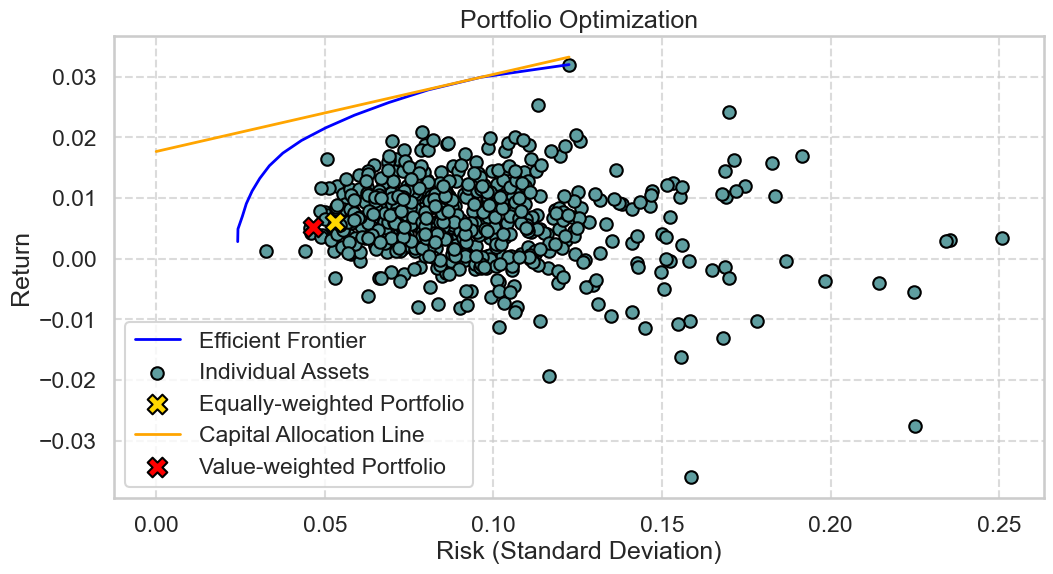

In [7]:
#Plotting the figure for question 3

# Set the style and context for the plot
sns.set_theme(style="whitegrid", context="talk")

# Calculate the performance of the equally-weighted portfolio
equal_weights = np.ones(n_assets) / n_assets
equal_weights_return = np.dot(equal_weights, mu_hat)
equal_weights_volatility = np.sqrt(np.dot(equal_weights.T, np.nan_to_num(np.dot(equal_weights, Sigma_hat))))


plt.figure(figsize=(12, 6))

# Plot the efficient frontier
plt.plot(efficient_frontier_df['Risk (Std Dev)'], efficient_frontier_df['Target Return'], label='Efficient Frontier', color='blue', linewidth=2)

# Plot the individual assets
plt.scatter(np.sqrt(np.diag(Sigma_hat)), mu_hat, marker='o', color='cadetblue', label='Individual Assets', edgecolors='black')

# Plot the equally-weighted portfolio
plt.scatter(equal_weights_volatility, equal_weights_return, marker='X', color='gold', label='Equally-weighted Portfolio', s=200, edgecolor='black')

# Plot the capital allocation line (CAL)
cal_x = np.linspace(0, max(efficient_frontier_df['Risk (Std Dev)']), 100)
cal_y = risk_free_rate + (cal_x * (highest_ex_ante_sharpe_portfolio['Target Return'] - risk_free_rate) / highest_ex_ante_sharpe_portfolio['Risk (Std Dev)'])
plt.plot(cal_x, cal_y, label='Capital Allocation Line', color='orange', linewidth=2)

# Plot the value-weighted portfolio
plt.scatter(value_weighted_returns_std, value_weighted_returns_mean, marker='X', color='red', label='Value-weighted Portfolio', s=200, edgecolor='black')

# Add labels and legend
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Portfolio Optimization')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Question 4

In [8]:
from scipy.optimize import minimize

file_path = r"data_h1/filtered_data/DS_RI_USD_M.xlsx"

#Filtering the data frame and using data only from 2014 to 2024
df_returns = pd.read_excel(file_path, sheet_name="MR raw", index_col=0, parse_dates=True)
df_returns = df_returns.select_dtypes(include=[np.number])
df_returns.columns = pd.to_datetime(df_returns.columns, format='%Y-%m-%d', errors='coerce')
df_returns = df_returns.loc[:, "2004-01-31":"2024-12-31"]

C:\Users\emmen\AppData\Local\Temp\ipykernel_10936\2396948825.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_returns = pd.read_excel(file_path, sheet_name="MR raw", index_col=0, parse_dates=True)


In [9]:
# Portfolio variance function
def portfolio_variance(w, Sigma):
    return w.T @ Sigma @ w

In [10]:
# Parameters
rolling_window_years = 10
months_per_year = 12
rolling_window_months = rolling_window_years * months_per_year

In [11]:
# Portfolio constraints
def get_constraints(n_assets):
    # Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    # No short selling
    bounds = [(0, 1) for _ in range(n_assets)]
    return constraints, bounds

In [12]:
# Rolling window optimization

# List to store the optimal weights for each year
optimal_weights_by_year = {}

# Iterate through years from 2013 to 2023
years = range(2013, 2024)

for Y in years:
    # Define end month for year Y (last month used in estimation)
    current_year_end = f"{Y}-12-31"
    
    # Define rolling window range: 10 years before current_year_end
    rolling_window_end = pd.to_datetime(current_year_end)
    rolling_window_start = rolling_window_end - pd.DateOffset(months=rolling_window_months - 1)
    
    # Select the data window
    window_columns = df_returns.loc[:, rolling_window_start:rolling_window_end]

    # Compute expected returns and covariance matrix over the window
    mu_hat_Yplus1 = window_columns.mean(axis=1, skipna=True).values.reshape(-1, 1)  
    Sigma_hat_Yplus1 = window_columns.T.cov().values                                
    
    # Replace NaNs in the covariance matrix
    Sigma_hat_Yplus1 = np.nan_to_num(Sigma_hat_Yplus1)

    n_assets = len(mu_hat_Yplus1)
    
    # Constraints and bounds
    constraints, bounds = get_constraints(n_assets)
    
    # Initial guess: equally weighted
    w0 = np.ones(n_assets) / n_assets
    
    # Solve minimum variance portfolio optimization
    result = minimize(portfolio_variance, w0, args=(Sigma_hat_Yplus1,), method='SLSQP',
                      bounds=bounds, constraints=constraints)
    
    # Store optimal weights
    if result.success:
        optimal_weights_by_year[Y + 1] = result.x
        print(f"Optimal weights for year {Y + 1} computed successfully.")
    else:
        print(f"Optimization failed for year {Y + 1}.")

Optimal weights for year 2014 computed successfully.
Optimal weights for year 2015 computed successfully.
Optimal weights for year 2016 computed successfully.
Optimal weights for year 2017 computed successfully.
Optimal weights for year 2018 computed successfully.
Optimal weights for year 2019 computed successfully.
Optimal weights for year 2020 computed successfully.
Optimal weights for year 2021 computed successfully.
Optimal weights for year 2022 computed successfully.
Optimal weights for year 2023 computed successfully.
Optimal weights for year 2024 computed successfully.


In [13]:
# Convert results to DataFrame

n_assets = df_returns.shape[0]
asset_names = [f"Asset {i+1}" for i in range(n_assets)]

optimal_weights_df = pd.DataFrame(optimal_weights_by_year).T
optimal_weights_df.columns = asset_names
optimal_weights_df.index.name = 'Year'

display(optimal_weights_df)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 613,Asset 614,Asset 615,Asset 616,Asset 617,Asset 618,Asset 619,Asset 620,Asset 621,Asset 622
Year,,,,,,,,,,,,,,,,,,,,,
2014,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,...,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03,1.607717e-03
2015,1.445462e-19,1.165165e-18,0.000000e+00,1.014842e-19,8.313181e-20,1.807275e-19,0.000000e+00,7.168118e-03,0.000000e+00,6.809167e-19,...,3.133088e-20,2.834827e-04,4.880757e-03,1.141063e-19,0.000000e+00,1.213864e-02,0.000000e+00,1.037858e-19,3.039101e-03,5.162832e-04
2016,0.000000e+00,2.199952e-03,6.238390e-20,0.000000e+00,0.000000e+00,7.122693e-19,0.000000e+00,0.000000e+00,2.363054e-19,0.000000e+00,...,1.257318e-19,0.000000e+00,1.129722e-19,1.739335e-19,0.000000e+00,0.000000e+00,4.239097e-20,1.813517e-19,1.644081e-03,0.000000e+00
2017,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.035321e-19,1.713740e-18,0.000000e+00,1.127418e-18,5.794190e-19,0.000000e+00,...,7.720928e-20,3.288047e-19,0.000000e+00,7.362033e-19,0.000000e+00,0.000000e+00,0.000000e+00,4.145276e-19,1.444643e-02,0.000000e+00
2018,2.762744e-18,0.000000e+00,7.538110e-19,1.094697e-18,0.000000e+00,1.786748e-18,0.000000e+00,0.000000e+00,3.997859e-20,1.592533e-18,...,3.626517e-19,0.000000e+00,1.166100e-20,0.000000e+00,2.681769e-19,4.515504e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2019,0.000000e+00,7.562844e-19,0.000000e+00,4.465344e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.643791e-19,7.900762e-19,...,6.866061e-19,1.814989e-19,4.985705e-20,3.285969e-19,2.454152e-19,2.224035e-20,0.000000e+00,6.235736e-19,0.000000e+00,5.458416e-20
2020,0.000000e+00,2.245902e-18,0.000000e+00,1.323223e-19,0.000000e+00,6.707897e-19,8.083231e-20,0.000000e+00,0.000000e+00,3.563856e-19,...,8.461610e-20,0.000000e+00,3.979356e-19,0.000000e+00,1.915357e-19,0.000000e+00,7.635853e-19,8.044061e-19,0.000000e+00,0.000000e+00
2021,3.264765e-19,0.000000e+00,1.595579e-18,1.033769e-18,6.504944e-19,9.538957e-19,5.596932e-19,0.000000e+00,0.000000e+00,5.916038e-19,...,0.000000e+00,0.000000e+00,4.089909e-19,0.000000e+00,1.364817e-19,0.000000e+00,0.000000e+00,0.000000e+00,3.343663e-19,0.000000e+00
2022,0.000000e+00,0.000000e+00,1.149031e-18,1.263667e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.584201e-19,0.000000e+00,...,2.375802e-19,8.417312e-22,0.000000e+00,6.145649e-19,0.000000e+00,6.326498e-20,6.282776e-20,3.873850e-19,0.000000e+00,2.815291e-20


In [14]:
# Save the weights to Excel
optimal_weights_df.to_excel("data_h1/results/optimal_weights_oos.xlsx")

In [ ]:
file_path = r"data_h1/filtered_data/DS_RI_USD_M.xlsx"

df_prices_raw = pd.read_excel(file_path, header=0)
df_prices_raw.set_index(df_prices_raw.columns[1], inplace=True)
price_columns = df_prices_raw.columns[2:]
df_prices = df_prices_raw.loc[:, price_columns]
df_prices.columns = pd.to_datetime(df_prices.columns, errors='coerce')
df_prices = df_prices.loc[:, ~df_prices.columns.isna()]

df_returns_raw = df_prices.copy()
df_returns_raw = df_returns_raw.replace({r'[%]': ''}, regex=True)
df_returns_raw = df_returns_raw.replace({',': '.'}, regex=True)
df_returns_raw = df_returns_raw.apply(pd.to_numeric, errors='coerce') / 100.0
df_returns = df_returns_raw.transpose()

df_returns_subset = df_returns.iloc[:, :622].copy()
df_returns_subset.columns = [f"Asset {i+1}" for i in range(df_returns_subset.shape[1])]

portfolio_returns = []

years = sorted(df_returns_subset.index.year.unique())

# Loop over each year for which previous year's weights are available
for year in years:
    if (year - 1) not in optimal_weights_df.index:
        print(f"Aucune pondération pour l'année {year - 1}, passage...")
        continue
    print("\nProcessing year", year)
    
    weights = optimal_weights_df.loc[year - 1].values.astype(float)
    
    monthly_returns = df_returns_subset[df_returns_subset.index.year == year].sort_index()
    print("monthly_returns shape for year", year, ":", monthly_returns.shape)
    
    for date, row in monthly_returns.iterrows():
        r = row.values.astype(float)
        # returns clipped
        r_clean = np.clip(r, -0.3, 0.3)
        
        port_ret = np.dot(weights, r_clean)
        portfolio_returns.append(port_ret)
        print(f"Year {year}, date {date.date()}, port_ret: {port_ret:.4%}")
        
        weights = weights * (1 + r_clean) / (1 + port_ret)
        weights = weights / weights.sum()

portfolio_returns = np.array(portfolio_returns)

avg_monthly_return = np.mean(portfolio_returns)
annualized_return = (1 + avg_monthly_return) ** 12 - 1
monthly_vol = np.std(portfolio_returns)
annualized_vol = monthly_vol * np.sqrt(12)
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol
min_return = np.min(portfolio_returns)
max_return = np.max(portfolio_returns)

print("\nPerformance du portefeuille optimisé (P(gmv)_oos):")
print(f"Rendement annualisé moyen: {annualized_return:.2%}")
print(f"Volatilité annualisée: {annualized_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Rendement mensuel minimum: {min_return:.2%}")
print(f"Rendement mensuel maximum: {max_return:.2%}")

vw_returns = value_weighted_returns
avg_vw = np.mean(vw_returns)
annualized_return_vw = (1 + avg_vw) ** 12 - 1
annualized_vol_vw = np.std(vw_returns) * np.sqrt(12)
sharpe_ratio_vw = (annualized_return_vw - risk_free_rate) / annualized_vol_vw
min_return_vw = np.min(vw_returns)
max_return_vw = np.max(vw_returns)

print("\nPerformance du portefeuille benchmark (P(vw)):")
print(f"Rendement annualisé moyen: {annualized_return_vw:.2%}")
print(f"Volatilité annualisée: {annualized_vol_vw:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_vw:.2f}")
print(f"Rendement mensuel minimum: {min_return_vw:.2%}")
print(f"Rendement mensuel maximum: {max_return_vw:.2%}")


Aucune pondération pour l'année 1999, passage...
Aucune pondération pour l'année 2000, passage...
Aucune pondération pour l'année 2001, passage...
Aucune pondération pour l'année 2002, passage...
Aucune pondération pour l'année 2003, passage...
Aucune pondération pour l'année 2004, passage...
Aucune pondération pour l'année 2005, passage...
Aucune pondération pour l'année 2006, passage...
Aucune pondération pour l'année 2007, passage...
Aucune pondération pour l'année 2008, passage...
Aucune pondération pour l'année 2009, passage...
Aucune pondération pour l'année 2010, passage...
Aucune pondération pour l'année 2011, passage...
Aucune pondération pour l'année 2012, passage...
Aucune pondération pour l'année 2013, passage...

Processing year 2015
monthly_returns shape for year 2015 : (12, 622)
Year 2015, date 2015-01-30, port_ret: nan%
Year 2015, date 2015-02-27, port_ret: nan%
Year 2015, date 2015-03-31, port_ret: nan%
Year 2015, date 2015-04-30, port_ret: nan%
Year 2015, date 2015-05